# ANLI with LLM

You have to implement in this notebook a better ANLI classifier using an LLM.
This classifier must be implemented using DSPy.


In [ ]:
from typing import Literal
from sentence_transformers import SentenceTransformer
import evaluate
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from typing import List, Dict, Any
from dotenv import load_dotenv
import os
import dspy
load_dotenv("grok_key.ini")  

lm = dspy.LM('xai/grok-3-mini', api_key=os.environ['XAI_API_KEY'])
dspy.configure(lm=lm)

## Load ANLI dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("facebook/anli")
dataset = dataset.filter(lambda x: x['reason'] != None and x['reason'] != "")

## Evaluate Metrics

Let's use the huggingface `evaluate` package to compute the performance of the baseline.


In [3]:
from evaluate import load

accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")


In [4]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

### DSPy Signatures and Modules 

In [ ]:
class JointPromptSignature(dspy.Signature):
    """Generate both an explanation and a label for the NLI task in one step."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis.")  
    label: Literal['entailment', 'neutral', 'contradiction'] = dspy.OutputField()

class PipelineExplanationSignature(dspy.Signature):
    """Generate an explanation for the relationship between premise and hypothesis."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis.")  

class PipelineResponseSignature(dspy.Signature):
    """Given an explanation, determine the entailment label."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.InputField(desc="Explanation of the relationship between premise and hypothesis.")
    label: Literal['entailment', 'neutral', 'contradiction'] = dspy.OutputField()

class PipelineModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.explanation_step = dspy.ChainOfThought(PipelineExplanationSignature)
        self.label_step = dspy.Predict(PipelineResponseSignature)
    
    def forward(self, premise, hypothesis):
        explanation_result = self.explanation_step(
            premise=premise, 
            hypothesis=hypothesis 
        )
        label_result = self.label_step(premise=premise, hypothesis=hypothesis, explanation=explanation_result.explanation)

        return dspy.Prediction(
            explanation=explanation_result.explanation,
            label=label_result.label
        )

# Initialize modules
joint_cot = dspy.ChainOfThought(JointPromptSignature)
pipeline_module = PipelineModule()

Initializing modules...
✓ Modules initialized


### Prepare Data for Evaluation

In [ ]:
def create_dspy_examples(dataset: List[Dict[str, Any]]) -> List[dspy.Example]:
    """
    Convert dataset to dspy.Example instances including the 'reason' field.
    """
    examples = []
    for item in dataset:
        if item.get('reason') and item['reason'].strip() != '':
            example = dspy.Example(
                premise=item['premise'],
                hypothesis=item['hypothesis'],
                label=item['label'],
                reason=item['reason']
            ).with_inputs('premise', 'hypothesis')
            
            examples.append(example)
    return examples

In [ ]:
# Load evaluation dataset 
print("Loading dev_r3 dataset...")
dev_dataset = load_dataset("anli", split="dev_r3")
# Filter examples without reasons
dev_with_reasons = [ex for ex in dev_dataset if ex.get('reason') and ex['reason'].strip() != '']
print(f"Found {len(dev_with_reasons)} examples with reasons out of {len(dev_dataset)} total")

Loading dev_r3 dataset...


README.md: 0.00B [00:00, ?B/s]

c:\Users\97252\Desktop\לימודים\סמסטר ו\LLM\hm2\nlp-with-llms-2025-hw2\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\97252\.cache\huggingface\hub\datasets--anli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fallin

train_r1-00000-of-00001.parquet:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


dev_r1-00000-of-00001.parquet:   0%|          | 0.00/351k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test_r1-00000-of-00001.parquet:   0%|          | 0.00/353k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train_r2-00000-of-00001.parquet:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


dev_r2-00000-of-00001.parquet:   0%|          | 0.00/351k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test_r2-00000-of-00001.parquet:   0%|          | 0.00/362k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train_r3-00000-of-00001.parquet:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


dev_r3-00000-of-00001.parquet:   0%|          | 0.00/434k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test_r3-00000-of-00001.parquet:   0%|          | 0.00/435k [00:00<?, ?B/s]

Generating train_r1 split:   0%|          | 0/16946 [00:00<?, ? examples/s]

Generating dev_r1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_r1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_r2 split:   0%|          | 0/45460 [00:00<?, ? examples/s]

Generating dev_r2 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_r2 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_r3 split:   0%|          | 0/100459 [00:00<?, ? examples/s]

Generating dev_r3 split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Generating test_r3 split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Found 1200 examples with reasons out of 1200 total


In [ ]:
dspy_eval_samples = create_dspy_examples(dev_with_reasons)

# Create a mapping from (premise, hypothesis) to reason so we can access reason in refine module without passing it to the LLM
REASON_MAP = {}

for ex in dspy_eval_samples:
    if isinstance(ex, dict):
        key = (ex['premise'], ex['hypothesis'])
        REASON_MAP[key] = ex.get('reason', '')
    else:  # dspy.Example
        key = (ex.premise, ex.hypothesis)
        REASON_MAP[key] = ex.get('reason', '')

### Similarity Analysis

In [9]:
similarity_model = SentenceTransformer("all-MiniLM-L6-v2")

def compute_similarity_scores(premise, hypothesis, human_reason, predicted_explanation):
    """
    Compute similarity scores between different text combinations.
    Returns a dictionary with all possible combinations.
    """
    # Combine premise and hypothesis
    premise_hypothesis = f"{premise} {hypothesis}"
    
    # Encode all texts
    texts = [premise_hypothesis, human_reason, predicted_explanation]
    embeddings = similarity_model.encode(texts)
    
    # Compute similarities
    similarities = similarity_model.similarity(embeddings, embeddings).numpy()
    
    # Extract individual similarities
    ph_hr_sim = similarities[0, 1]  # premise+hypothesis vs human_reason
    ph_pe_sim = similarities[0, 2]  # premise+hypothesis vs predicted_explanation
    hr_pe_sim = similarities[1, 2]  # human_reason vs predicted_explanation
    
    # Handle division by zero
    def safe_divide(a, b):
        return a / b if b != 0 else 0
    
    return {
        'A': ph_hr_sim,  # (premise, hypothesis) vs human_reason
        'B': hr_pe_sim,  # human_reason vs predicted_explanation
        'C': ph_pe_sim,  # (premise, hypothesis) vs predicted_explanation
        'A/B': safe_divide(ph_hr_sim, hr_pe_sim),
        'A/C': safe_divide(ph_hr_sim, ph_pe_sim),
        'B/C': safe_divide(hr_pe_sim, ph_pe_sim)
    }

In [ ]:
from matplotlib import pyplot as plt
def create_similarity_histograms(results, approach_name):
    df = pd.DataFrame(results)
    correct_df = df[df['is_correct'] == True]
    incorrect_df = df[df['is_correct'] == False]
    
    metrics = ['A', 'B', 'C', 'A/B', 'A/C', 'B/C']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'{approach_name} - Similarity Metrics Distribution: Correct vs Incorrect Predictions', fontsize=16)
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        correct_values = correct_df[metric].values
        incorrect_values = incorrect_df[metric].values
        
        # Determine range for histogram bins
        all_values = np.concatenate([correct_values, incorrect_values])
        min_val, max_val = np.min(all_values), np.max(all_values)
        
        # Create bins
        if metric in ['A', 'B', 'C']:  # Similarity scores are between 0 and 1
            bins = np.linspace(0, 1, 21)  
        else:  # Ratio metrics can have wider range
            bins = np.linspace(min_val, max_val, 21)
        
        ax.hist(correct_values, bins=bins, alpha=0.7, label='Correct', color='green', edgecolor='black')
        ax.hist(incorrect_values, bins=bins, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
        ax.set_xlabel(f'{metric} Score')
        ax.set_ylabel('Count')
        ax.set_title(f'Metric {metric}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        correct_mean = np.mean(correct_values) if len(correct_values) > 0 else 0
        incorrect_mean = np.mean(incorrect_values) if len(incorrect_values) > 0 else 0
        ax.text(0.05, 0.95, f'Correct μ: {correct_mean:.3f}\nIncorrect μ: {incorrect_mean:.3f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig

### Evaluation Functions

In [ ]:
from dspy.evaluate import Evaluate

def create_evaluator_metric(module, collect_similarity=False):
    """Create a metric function compatible with dspy.Evaluate"""
    LABEL_MAP = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
    results_collector = [] if collect_similarity else None
    
    def metric(example, prediction, trace=None):
        # Handle the case where prediction might be the module output
        if hasattr(prediction, 'label'):
            pred_label = prediction.label
            pred_explanation = prediction.explanation
        else:
            # If not, run the module
            pred = module(premise=example.premise, hypothesis=example.hypothesis)
            pred_label = pred.label
            pred_explanation = pred.explanation
        
        pred_label_int = LABEL_MAP.get(pred_label.lower().strip(), -1)
        true_label = example.label
        is_correct = pred_label_int == true_label
        
        # Collect similarity scores if requested
        if collect_similarity and hasattr(example, 'reason') and example.reason:
            sim_scores = compute_similarity_scores(
                premise=example.premise,
                hypothesis=example.hypothesis,
                human_reason=example.reason,
                predicted_explanation=pred_explanation
            )
            results_collector.append({
                'premise': example.premise,
                'hypothesis': example.hypothesis,
                'true_label': true_label,
                'predicted_label': pred_label,
                'human_reason': example.reason,
                'predicted_explanation': pred_explanation,
                'is_correct': is_correct,
                **sim_scores
            })
        
        return is_correct
    
    return metric, results_collector

def evaluate_with_similarity_parallel(module, dataset, num_threads=4, collect_results=False):
    """
    Parallel evaluation using dspy.Evaluate while maintaining similarity analysis
    """
    metric_fn, results_collector = create_evaluator_metric(module, collect_results)
    
    filtered_dataset = []
    for ex in dataset:
        if isinstance(ex, dspy.Example) and hasattr(ex, 'reason') and ex.reason:
            filtered_dataset.append(ex)
        elif isinstance(ex, dict) and ex.get('reason'):
            # Convert dict to dspy.Example if needed
            filtered_dataset.append(dspy.Example(**ex).with_inputs('premise', 'hypothesis'))
    
    evaluator = Evaluate(
        devset=filtered_dataset,
        metric=metric_fn,
        num_threads=num_threads,
        display_progress=True,
        display_table=0
    )
    accuracy = evaluator(module)
    
    return accuracy, results_collector if collect_results else []


### Evaluate Basic Modules 

In [11]:
joint_accuracy, joint_results = evaluate_with_similarity_parallel(
    joint_cot,
    dspy_eval_samples[:200],
    num_threads=4,
    collect_results=True
)
print(f"Joint CoT Accuracy: {joint_accuracy:.3f}")

Average Metric: 143.00 / 200 (71.5%): 100%|██████████| 200/200 [05:42<00:00,  1.71s/it]

2025/08/04 11:50:34 INFO dspy.evaluate.evaluate: Average Metric: 143 / 200 (71.5%)



Joint CoT Accuracy: 71.500


In [12]:
pipeline_accuracy, pipeline_results = evaluate_with_similarity_parallel(
    pipeline_module,
    dspy_eval_samples[:200],
    num_threads=4,  
    collect_results=True
)
print(f"Pipeline Module Accuracy: {pipeline_accuracy:.3f}")

  0%|          | 0/200 [00:00<?, ?it/s]

Average Metric: 150.00 / 200 (75.0%): 100%|██████████| 200/200 [08:25<00:00,  2.53s/it]

2025/08/04 11:59:13 INFO dspy.evaluate.evaluate: Average Metric: 150 / 200 (75.0%)



Pipeline Module Accuracy: 75.000


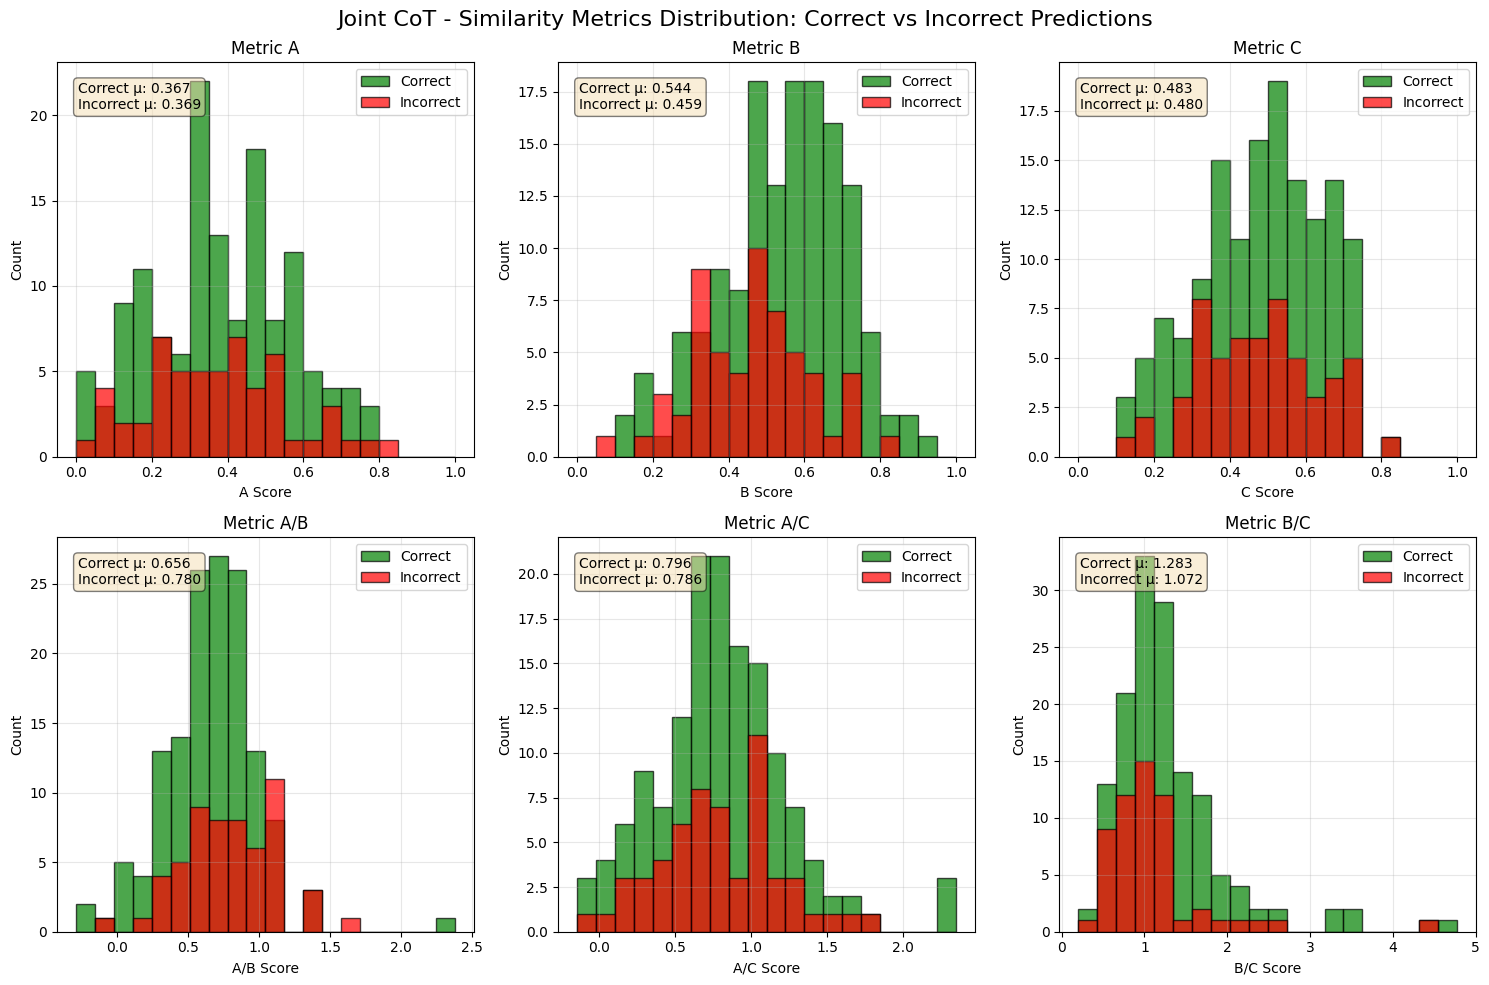

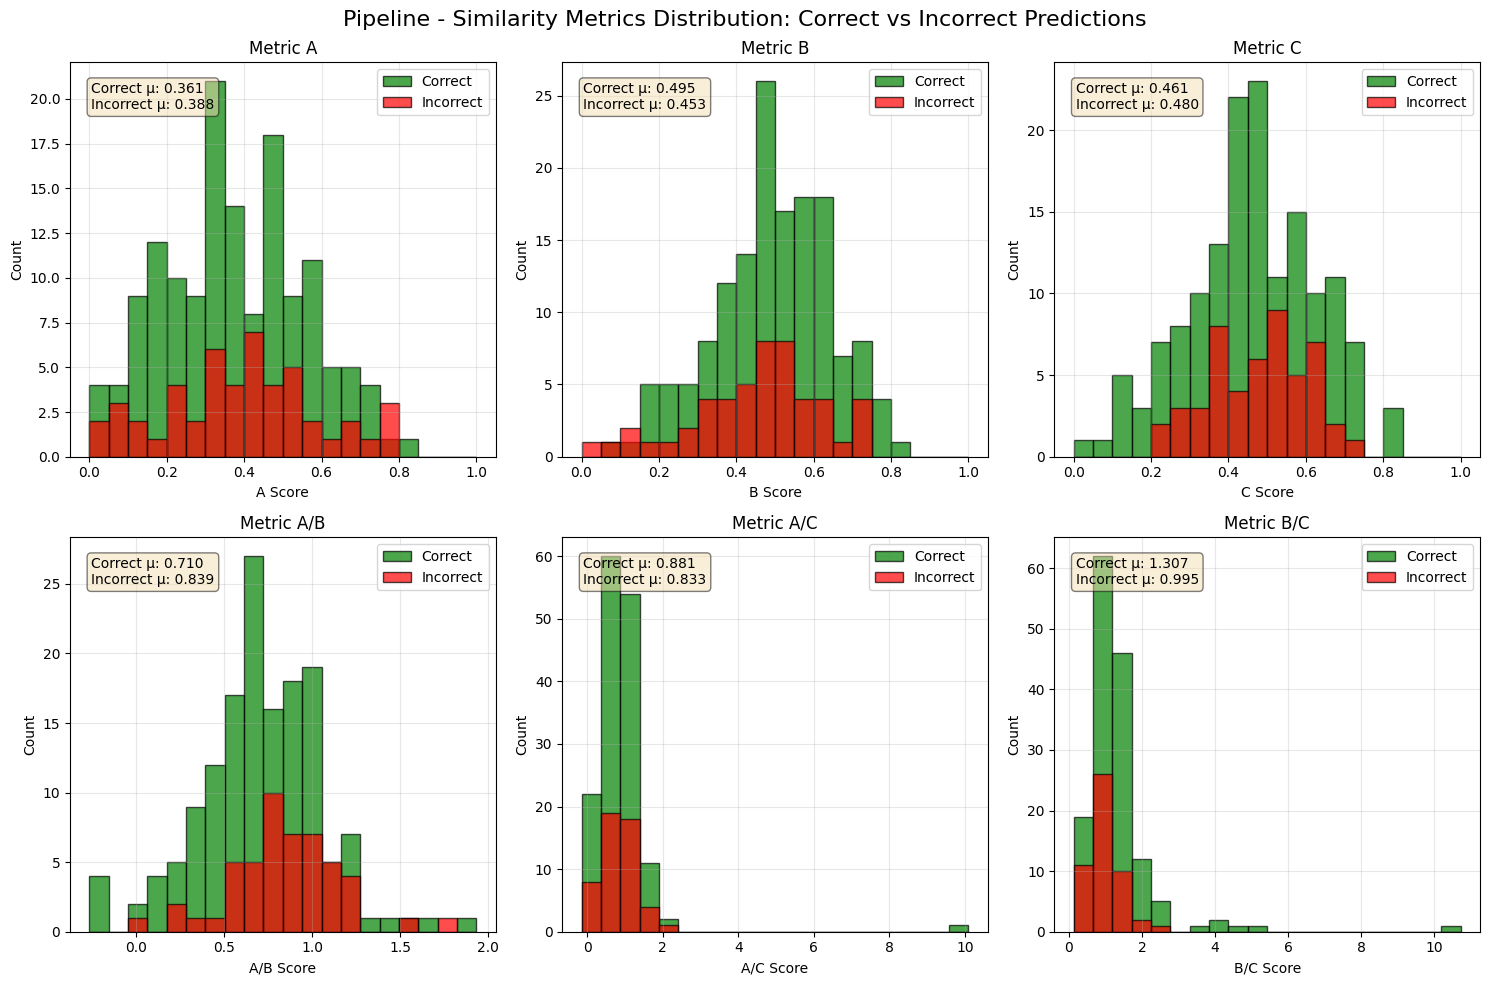

In [16]:
joint_fig = create_similarity_histograms(joint_results, "Joint CoT")
plt.show()

pipeline_fig = create_similarity_histograms(pipeline_results, "Pipeline")
plt.show()

### Observations 



#### Accuracy:

Joint CoT: 0.735

Pipeline: 0.745



#### Probable Ranges of Scores for Correct Label:

##### Joint CoT:

Metric A: 0.0 - 0.6 

Metric B: 0.45 - 0.85

Metric A/B: 0.0 - 1.25

Metric A/C: 0.0 - 1.25


##### Pipeline:

Metric A: 0.1 - 0.85

Metric B: 0.2 - 0.8

Metric A/B: 0.0 - 1.9

Metric B/C: over 0.5


### Adding the Refine Module with Similarity Thresholds

We designed the reward function for the Refine Modules by first performing a statistical analysis on the relationship between different similarity metrics and the performance of the model. We visualized the results using a histogram so that we could fine thresholds which we could use for our Refine Module. The reward function encouraged the model to stay within the thresholds of the where the model performed best. 

In [13]:
def joint_similarity_reward(example, pred: dspy.Prediction) -> float:
    key = (example['premise'], example['hypothesis'])
    reason = REASON_MAP.get(key, '')
    
    score = 0.0
    similarity_scores = compute_similarity_scores(
        example['premise'],     
        example['hypothesis'],  
        reason,
        pred.explanation
    )

    if 0.0 <= similarity_scores['A'] <= 0.6:
        score += 1.0
    if 0.45 <= similarity_scores['B'] <= 0.85:
        score += 1.0
    if 0.0 <= similarity_scores['A/B'] <= 1.25:
        score += 1.0
    if 0.0 <= similarity_scores['A/C'] <= 1.25:
        score += 1.0

    return score

def pipeline_similarity_reward(example, pred: dspy.Prediction) -> float:
    key = (example['premise'], example['hypothesis'])
    reason = REASON_MAP.get(key, '')

    score = 0.0
    similarity_scores = compute_similarity_scores(
        example['premise'],      
        example['hypothesis'],  
        reason, 
        pred.explanation
    )
    
    if 0.1 <= similarity_scores['A'] <= 0.85:
        score += 1
    if 0.2 <= similarity_scores['B'] <= 0.8:
        score += 1
    if 0.0 <= similarity_scores['A/B'] <= 1.9:
        score += 1
    if 0.5 <= similarity_scores['B/C']:
        score += 1.0

    return score


refined_joint = dspy.Refine(
    module=joint_cot, 
    N=3, 
    reward_fn=joint_similarity_reward, 
    threshold=4.0
)

refined_pipeline = dspy.Refine(
    module=pipeline_module, 
    N=3, 
    reward_fn=pipeline_similarity_reward, 
    threshold=4.0
)

### Evaluation with Refine Module

In [14]:
refined_joint_accuracy, refined_joint_results = evaluate_with_similarity_parallel(
    refined_joint,
    dspy_eval_samples[:200],
    num_threads=4,  
    collect_results=True
)
print(f"Refined Joint CoT Accuracy: {refined_joint_accuracy:.3f}")

Average Metric: 144.00 / 200 (72.0%): 100%|██████████| 200/200 [14:56<00:00,  4.48s/it]

2025/08/04 12:17:09 INFO dspy.evaluate.evaluate: Average Metric: 144 / 200 (72.0%)



Refined Joint CoT Accuracy: 72.000


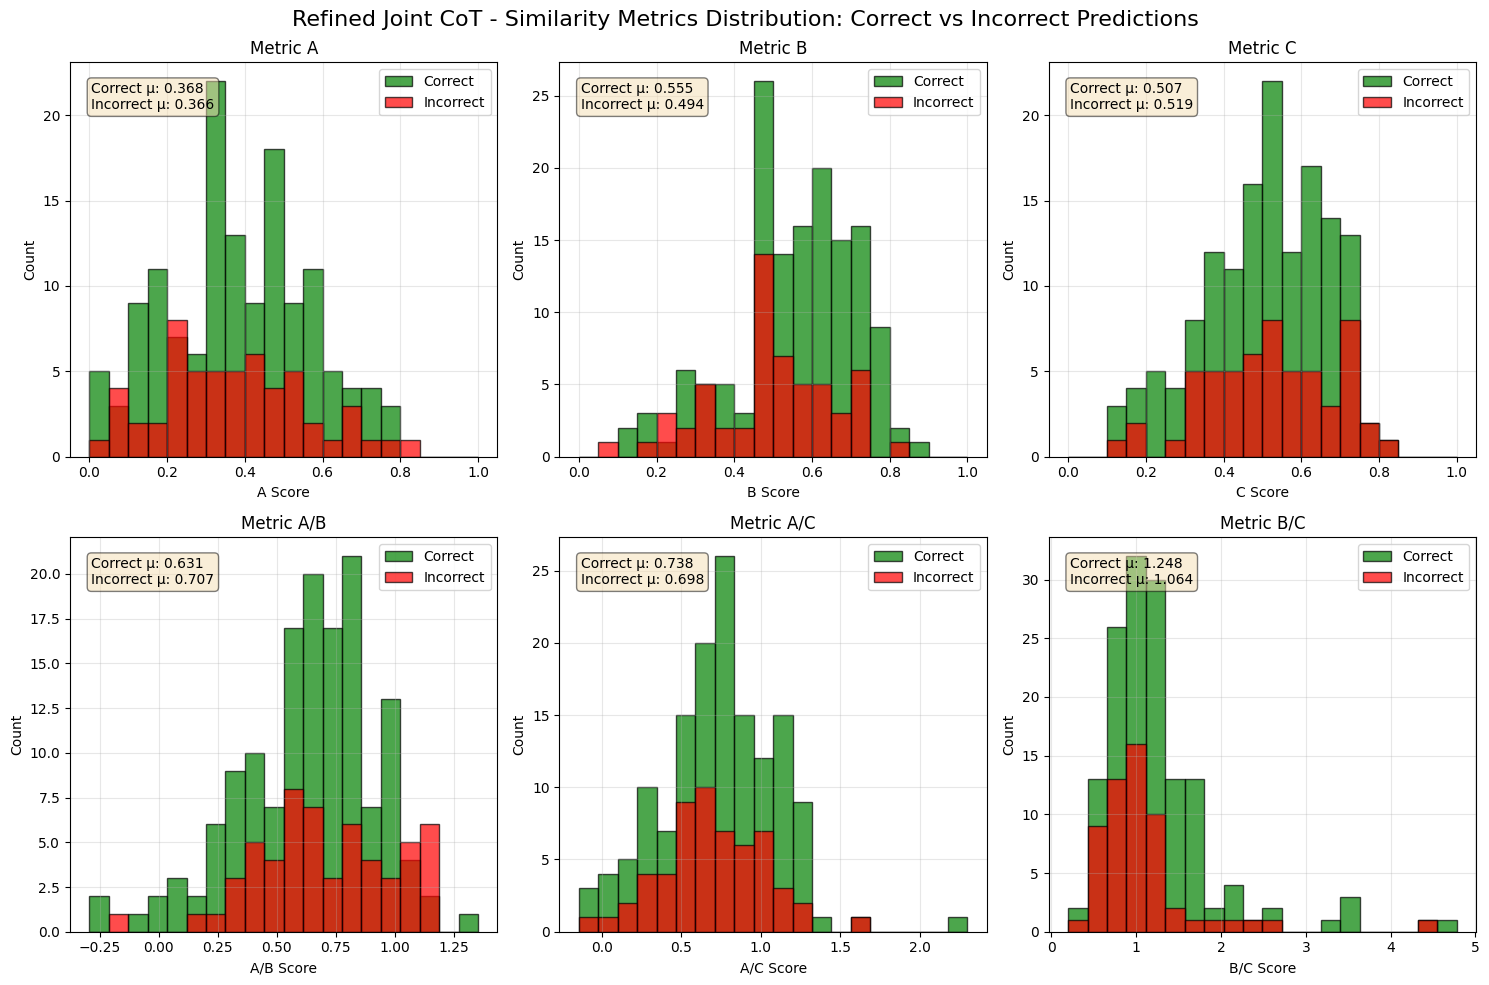

In [17]:
joint_fig = create_similarity_histograms(refined_joint_results, "Refined Joint CoT")
plt.show()

In [18]:
refined_pipeline_accuracy, refined_pipeline_results = evaluate_with_similarity_parallel(
    refined_pipeline,
    dspy_eval_samples[:200],
    num_threads=8,  
    collect_results=True
)
print(f"Refined Pipeline Module Accuracy: {refined_pipeline_accuracy:.3f}")

Average Metric: 150.00 / 200 (75.0%): 100%|██████████| 200/200 [03:34<00:00,  1.07s/it]

2025/08/04 12:20:50 INFO dspy.evaluate.evaluate: Average Metric: 150 / 200 (75.0%)



Refined Pipeline Module Accuracy: 75.000


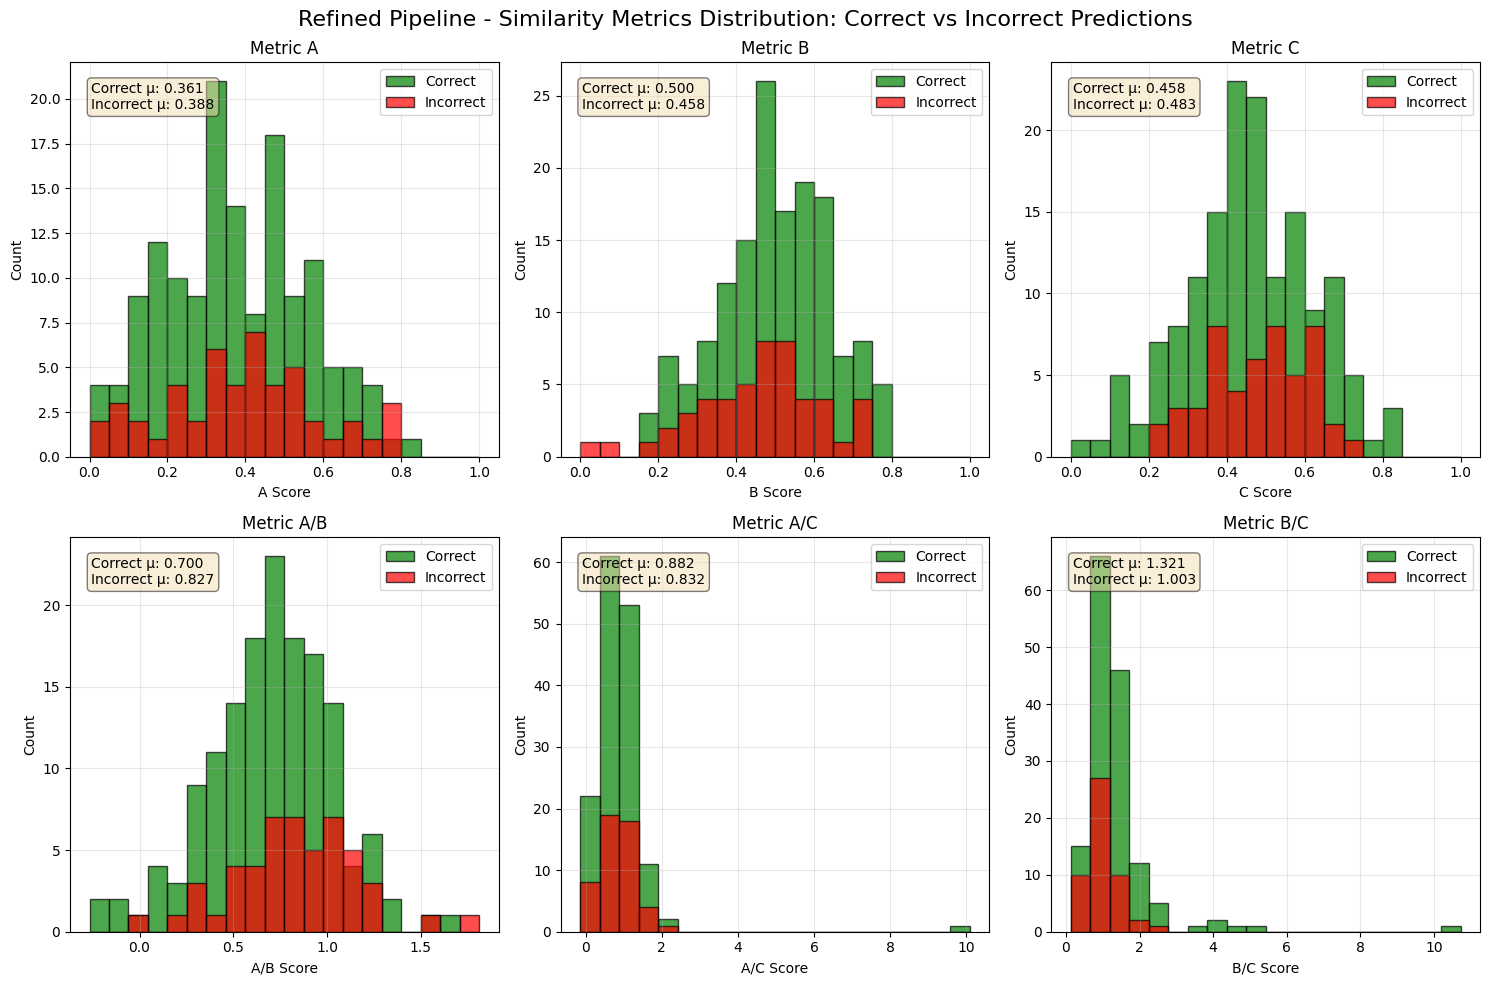

In [19]:
pipeline_fig = create_similarity_histograms(refined_pipeline_results, "Refined Pipeline")
plt.show()

### Refine Module Discussion 

Refined Joint CoT: 

After adding the Refine Module to the Joint CoT Module with the similarity thresholds we found in our analysis, we saw that our accuracy improved from 0.715 to 0.72. 

Refined Pipeline:

After adding the Refine Module to the Pipeline Module with the similarity thresholds we found in our analysis, we saw that our accuracy stayed 0.75

### Optimize Modules

In [ ]:
from dspy import MIPROv2

def exact_match(pred, gold, trace=None):
    try:
        label_names = ["entailment", "neutral", "contradiction"]
        label2id = {label: i for i, label in enumerate(label_names)}
        pred_label = getattr(pred, 'label', pred)
        gold_label = getattr(gold, 'label', gold)
        
        # Convert pred_label to numeric if it's a string
        if isinstance(pred_label, str):
            pred_label_id = label2id.get(pred_label.strip().lower(), -1)
        else:
            pred_label_id = pred_label
            
        # Convert gold_label to numeric if it's a string
        if isinstance(gold_label, str):
            gold_label_id = label2id.get(gold_label.strip().lower(), -1)
        else:
            gold_label_id = gold_label
            
        return pred_label_id == gold_label_id
        
    except Exception as e:
        print(f"Error in exact_match: {e}, pred={pred_label}, gold={gold_label}")
        return False

In [22]:
optimizer = MIPROv2(metric=exact_match)

### Train Optimizer On Refined Modules

In [23]:
optimized_joint = optimizer.compile(
    refined_joint,
    trainset=dspy_eval_samples[:100],
    requires_permission_to_run=False  
)

2025/08/04 12:23:07 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 80

2025/08/04 12:23:07 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/04 12:23:07 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/04 12:23:07 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


 30%|███       | 6/20 [02:18<05:23, 23.11s/it]


Bootstrapped 4 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.
Bootstrapping set 4/6


 15%|█▌        | 3/20 [01:04<06:04, 21.43s/it]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Bootstrapping set 5/6


 15%|█▌        | 3/20 [01:20<07:35, 26.77s/it]


Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Bootstrapping set 6/6


  5%|▌         | 1/20 [00:44<14:10, 44.74s/it]
2025/08/04 12:28:43 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/04 12:28:43 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Error getting source code: unhashable type: 'dict'.

Running without program aware proposer.


2025/08/04 12:29:05 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/08/04 12:29:29 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/04 12:29:29 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Generate both an explanation and a label for the NLI task in one step.

2025/08/04 12:29:29 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are tasked with performing Natural Language Inference (NLI) on pairs of premises and hypotheses. For each pair, analyze whether the hypothesis logically entails the premise. Keep in mind that hypotheses often involve unsubstantiated inferences, ambiguities, or misalignments with the premise, which typically results in non-entailment.

Your response should include:
1. An explanation: Provide a clear, step-by-step reasoning of why the hypothesis entails (or does not entail) the premise, focusing on direct evidence, potential over-inferences, or ambiguities in the language.
2. A label: Output 1 if 

Average Metric: 54.00 / 80 (67.5%): 100%|██████████| 80/80 [00:56<00:00,  1.42it/s] 

2025/08/04 12:30:31 INFO dspy.evaluate.evaluate: Average Metric: 54 / 80 (67.5%)
2025/08/04 12:30:31 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 67.5



c:\Users\97252\Desktop\לימודים\סמסטר ו\LLM\hm2\nlp-with-llms-2025-hw2\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/08/04 12:30:31 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|██████████| 35/35 [02:27<00:00,  4.22s/it]

2025/08/04 12:33:00 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)
2025/08/04 12:33:00 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/04 12:33:00 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14]
2025/08/04 12:33:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5]
2025/08/04 12:33:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.5
2025/08/04 12:33:00 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 12:33:00 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==



Average Metric: 21.00 / 35 (60.0%): 100%|██████████| 35/35 [02:34<00:00,  4.40s/it]

2025/08/04 12:35:38 INFO dspy.evaluate.evaluate: Average Metric: 21 / 35 (60.0%)
2025/08/04 12:35:38 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/04 12:35:38 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0]
2025/08/04 12:35:38 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5]
2025/08/04 12:35:38 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.5
2025/08/04 12:35:38 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 12:35:38 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==



Average Metric: 21.00 / 35 (60.0%): 100%|██████████| 35/35 [02:49<00:00,  4.85s/it]

2025/08/04 12:38:29 INFO dspy.evaluate.evaluate: Average Metric: 21 / 35 (60.0%)


2025/08/04 12:38:29 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/08/04 12:38:29 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 60.0]
2025/08/04 12:38:29 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5]
2025/08/04 12:38:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.5
2025/08/04 12:38:29 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 12:38:29 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [03:09<00:00,  5.41s/it]

2025/08/04 12:41:41 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/04 12:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/08/04 12:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 60.0, 65.71]
2025/08/04 12:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5]
2025/08/04 12:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.5
2025/08/04 12:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 12:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [02:37<00:00,  4.49s/it]

2025/08/04 12:44:19 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/04 12:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/08/04 12:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 60.0, 65.71, 65.71]
2025/08/04 12:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5]
2025/08/04 12:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.5
2025/08/04 12:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 12:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/08/04 12:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 77.14) from minibatch trials...



Average Metric: 56.00 / 80 (70.0%): 100%|██████████| 80/80 [05:33<00:00,  4.17s/it]

2025/08/04 12:49:55 INFO dspy.evaluate.evaluate: Average Metric: 56 / 80 (70.0%)
2025/08/04 12:49:55 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 70.0


2025/08/04 12:49:55 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5, 70.0]
2025/08/04 12:49:55 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 12:49:55 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/04 12:49:55 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/04 12:49:55 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [02:04<00:00,  3.55s/it]

2025/08/04 12:52:01 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/04 12:52:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/04 12:52:02 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 60.0, 65.71, 65.71, 65.71]
2025/08/04 12:52:02 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5, 70.0]
2025/08/04 12:52:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 12:52:02 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 12:52:02 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==



Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [03:05<00:00,  5.31s/it]

2025/08/04 12:55:13 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)
2025/08/04 12:55:13 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/08/04 12:55:13 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 60.0, 65.71, 65.71, 65.71, 62.86]
2025/08/04 12:55:13 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5, 70.0]
2025/08/04 12:55:13 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 12:55:13 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 12:55:13 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [03:07<00:00,  5.35s/it]

2025/08/04 12:58:21 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)
2025/08/04 12:58:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/08/04 12:58:22 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 60.0, 65.71, 65.71, 65.71, 62.86, 68.57]


2025/08/04 12:58:22 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5, 70.0]
2025/08/04 12:58:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 12:58:22 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 12:58:22 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==


Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]

2025/08/04 12:58:57 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)


2025/08/04 12:58:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/04 12:58:57 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 60.0, 65.71, 65.71, 65.71, 62.86, 68.57, 71.43]
2025/08/04 12:58:57 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5, 70.0]
2025/08/04 12:58:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 12:58:57 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 12:58:57 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==


Average Metric: 20.00 / 35 (57.1%): 100%|██████████| 35/35 [00:31<00:00,  1.10it/s]

2025/08/04 12:59:31 INFO dspy.evaluate.evaluate: Average Metric: 20 / 35 (57.1%)


2025/08/04 12:59:35 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 57.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/04 12:59:35 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 60.0, 60.0, 65.71, 65.71, 65.71, 62.86, 68.57, 71.43, 57.14]
2025/08/04 12:59:35 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5, 70.0]
2025/08/04 12:59:35 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 12:59:35 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 12:59:35 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/08/04 12:59:35 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 68.57) from minibatch trials...


Average Metric: 56.00 / 80 (70.0%): 100%|██████████| 80/80 [05:46<00:00,  4.33s/it]

2025/08/04 13:05:23 INFO dspy.evaluate.evaluate: Average Metric: 56 / 80 (70.0%)
2025/08/04 13:05:23 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.5, 70.0, 70.0]
2025/08/04 13:05:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 13:05:23 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/04 13:05:23 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/04 13:05:23 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 70.0!


In [ ]:
optimized_pipeline = optimizer.compile(
    refined_pipeline,
    trainset=dspy_eval_samples[:100],
    requires_permission_to_run=False  
)

2025/08/04 14:00:13 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 20
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 80

2025/08/04 14:00:14 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/04 14:00:14 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/04 14:00:14 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


 20%|██        | 4/20 [01:37<06:28, 24.26s/it]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 4/6


 15%|█▌        | 3/20 [00:15<01:26,  5.07s/it]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Bootstrapping set 5/6


 10%|█         | 2/20 [00:09<01:22,  4.61s/it]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/6


  5%|▌         | 1/20 [00:03<01:07,  3.57s/it]
2025/08/04 14:02:21 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/04 14:02:21 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/08/04 14:02:21 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...



Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Error getting source code: unhashable type: 'dict'.

Running without program aware proposer.


2025/08/04 14:03:17 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/04 14:03:17 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Generate an explanation for the relationship between premise and hypothesis.

2025/08/04 14:03:17 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Given a premise and a hypothesis from a Natural Language Inference dataset, analyze their relationship and generate a clear, detailed explanation. Specifically, determine whether the hypothesis is entailed by the premise (i.e., it logically follows), contradicts the premise, or is neutral (i.e., neither supported nor contradicted). In your explanation, highlight any instances of over-inference, ambiguity, or unsupported assumptions in the hypothesis, and base your analysis on the content of the premise. Ensure your response is concise, reasoned, and focused on evidence from the premise.

2025/08/04 14:03:17 INFO dspy.teleprompt.mipro_optimizer_v2: 2: Analyze the given premise and hypo

Average Metric: 53.00 / 80 (66.2%): 100%|██████████| 80/80 [00:56<00:00,  1.41it/s]

2025/08/04 14:04:27 INFO dspy.evaluate.evaluate: Average Metric: 53 / 80 (66.2%)
2025/08/04 14:04:27 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 66.25



c:\Users\97252\Desktop\לימודים\סמסטר ו\LLM\hm2\nlp-with-llms-2025-hw2\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/08/04 14:04:28 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 25 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [03:03<00:00,  5.24s/it]

2025/08/04 14:07:33 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)


2025/08/04 14:07:34 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 0'].
2025/08/04 14:07:34 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86]
2025/08/04 14:07:34 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25]
2025/08/04 14:07:34 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.25
2025/08/04 14:07:34 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 14:07:34 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 25 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [02:06<00:00,  3.60s/it]

2025/08/04 14:09:42 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/04 14:09:42 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2025/08/04 14:09:42 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71]
2025/08/04 14:09:42 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25]
2025/08/04 14:09:42 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.25
2025/08/04 14:09:42 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 14:09:42 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 25 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [02:05<00:00,  3.59s/it]

2025/08/04 14:11:56 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)


2025/08/04 14:11:56 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 0'].
2025/08/04 14:11:56 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57]
2025/08/04 14:11:56 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25]
2025/08/04 14:11:56 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.25
2025/08/04 14:11:56 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 14:11:56 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 25 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [02:46<00:00,  4.74s/it]

2025/08/04 14:14:57 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)


2025/08/04 14:14:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 4'].
2025/08/04 14:14:57 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71]
2025/08/04 14:14:57 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25]
2025/08/04 14:14:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.25
2025/08/04 14:14:57 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 14:14:57 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 25 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [02:08<00:00,  3.67s/it]

2025/08/04 14:17:15 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)
2025/08/04 14:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2025/08/04 14:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86]
2025/08/04 14:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25]
2025/08/04 14:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.25
2025/08/04 14:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 14:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 25 - Full Evaluation =====
2025/08/04 14:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 68.57) from minibatch trials...



Average Metric: 56.00 / 80 (70.0%): 100%|██████████| 80/80 [02:48<00:00,  2.10s/it]

2025/08/04 14:20:05 INFO dspy.evaluate.evaluate: Average Metric: 56 / 80 (70.0%)
2025/08/04 14:20:05 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 70.0


2025/08/04 14:20:05 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0]
2025/08/04 14:20:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:20:05 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/04 14:20:05 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/04 14:20:05 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 25 - Minibatch ==


Average Metric: 21.00 / 35 (60.0%): 100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

2025/08/04 14:20:41 INFO dspy.evaluate.evaluate: Average Metric: 21 / 35 (60.0%)
2025/08/04 14:20:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 0'].


2025/08/04 14:20:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0]
2025/08/04 14:20:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0]
2025/08/04 14:20:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:20:41 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 14:20:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 25 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [01:52<00:00,  3.20s/it]

2025/08/04 14:22:35 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)
2025/08/04 14:22:35 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 1'].
2025/08/04 14:22:35 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86]
2025/08/04 14:22:35 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0]
2025/08/04 14:22:35 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:22:35 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/04 14:22:35 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 25 - Minibatch ==



Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [01:40<00:00,  2.88s/it]

2025/08/04 14:24:19 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)
2025/08/04 14:24:19 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 0'].
2025/08/04 14:24:19 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43]
2025/08/04 14:24:19 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0]
2025/08/04 14:24:19 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:24:19 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:24:19 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 25 - Minibatch ==



Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [01:32<00:00,  2.64s/it]

2025/08/04 14:25:54 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)
2025/08/04 14:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 3'].
2025/08/04 14:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86]
2025/08/04 14:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0]
2025/08/04 14:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 25 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [01:30<00:00,  2.59s/it]

2025/08/04 14:27:26 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/04 14:27:26 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 2'].
2025/08/04 14:27:26 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71]
2025/08/04 14:27:26 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0]
2025/08/04 14:27:26 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:27:26 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:27:26 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 25 - Full Evaluation =====
2025/08/04 14:27:26 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 71.43


Average Metric: 50.00 / 80 (62.5%): 100%|██████████| 80/80 [02:25<00:00,  1.82s/it]

2025/08/04 14:30:03 INFO dspy.evaluate.evaluate: Average Metric: 50 / 80 (62.5%)
2025/08/04 14:30:03 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5]
2025/08/04 14:30:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:30:03 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/04 14:30:03 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/04 14:30:03 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 14 / 25 - Minibatch ==



Average Metric: 28.00 / 35 (80.0%): 100%|██████████| 35/35 [01:16<00:00,  2.18s/it]

2025/08/04 14:31:23 INFO dspy.evaluate.evaluate: Average Metric: 28 / 35 (80.0%)
2025/08/04 14:31:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2025/08/04 14:31:23 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71, 80.0]
2025/08/04 14:31:23 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5]
2025/08/04 14:31:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:31:23 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:31:23 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 15 / 25 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [00:56<00:00,  1.62s/it]

2025/08/04 14:32:21 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)
2025/08/04 14:32:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 5'].
2025/08/04 14:32:22 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71, 80.0, 68.57]
2025/08/04 14:32:22 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5]
2025/08/04 14:32:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:32:22 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:32:22 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 16 / 25 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [00:21<00:00,  1.62it/s]

2025/08/04 14:32:45 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)


2025/08/04 14:32:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 0'].
2025/08/04 14:32:46 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71, 80.0, 68.57, 68.57]
2025/08/04 14:32:46 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5]
2025/08/04 14:32:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:32:46 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:32:46 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 17 / 25 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [01:50<00:00,  3.15s/it]

2025/08/04 14:34:49 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)


2025/08/04 14:34:50 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 1'].
2025/08/04 14:34:50 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71, 80.0, 68.57, 68.57, 65.71]
2025/08/04 14:34:50 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5]
2025/08/04 14:34:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:34:50 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:34:50 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 18 / 25 - Minibatch ==


Average Metric: 26.00 / 35 (74.3%): 100%|██████████| 35/35 [01:57<00:00,  3.36s/it]

2025/08/04 14:36:49 INFO dspy.evaluate.evaluate: Average Metric: 26 / 35 (74.3%)


2025/08/04 14:36:49 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 5'].
2025/08/04 14:36:49 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71, 80.0, 68.57, 68.57, 65.71, 74.29]
2025/08/04 14:36:49 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5]
2025/08/04 14:36:49 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:36:49 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:36:49 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 19 / 25 - Full Evaluation =====
2025/08/04 14:36:49 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 80.0) from minibatch trials...


Average Metric: 56.00 / 80 (70.0%): 100%|██████████| 80/80 [02:04<00:00,  1.56s/it]

2025/08/04 14:38:56 INFO dspy.evaluate.evaluate: Average Metric: 56 / 80 (70.0%)
2025/08/04 14:38:56 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5, 70.0]
2025/08/04 14:38:56 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:38:56 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/04 14:38:56 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/04 14:38:56 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 20 / 25 - Minibatch ==



Average Metric: 26.00 / 35 (74.3%): 100%|██████████| 35/35 [01:00<00:00,  1.73s/it]

2025/08/04 14:39:59 INFO dspy.evaluate.evaluate: Average Metric: 26 / 35 (74.3%)
2025/08/04 14:40:00 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 4', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 5'].


2025/08/04 14:40:00 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71, 80.0, 68.57, 68.57, 65.71, 74.29, 74.29]
2025/08/04 14:40:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5, 70.0]
2025/08/04 14:40:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:40:00 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:40:00 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 21 / 25 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [00:52<00:00,  1.51s/it]

2025/08/04 14:40:55 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/04 14:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 4'].
2025/08/04 14:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71, 80.0, 68.57, 68.57, 65.71, 74.29, 74.29, 65.71]
2025/08/04 14:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5, 70.0]
2025/08/04 14:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 22 / 25 - Minibatch ==



Average Metric: 27.00 / 35 (77.1%): 100%|██████████| 35/35 [00:45<00:00,  1.31s/it]

2025/08/04 14:41:59 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)


2025/08/04 14:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 4', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 5'].
2025/08/04 14:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71, 80.0, 68.57, 68.57, 65.71, 74.29, 74.29, 65.71, 77.14]
2025/08/04 14:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5, 70.0]
2025/08/04 14:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 23 / 25 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [01:58<00:00,  3.37s/it]

2025/08/04 14:43:59 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)


2025/08/04 14:43:59 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 5'].
2025/08/04 14:43:59 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71, 80.0, 68.57, 68.57, 65.71, 74.29, 74.29, 65.71, 77.14, 65.71]
2025/08/04 14:43:59 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5, 70.0]
2025/08/04 14:43:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:43:59 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:43:59 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 24 / 25 - Minibatch ==


Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [01:40<00:00,  2.88s/it]

2025/08/04 14:45:43 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)


2025/08/04 14:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 5'].
2025/08/04 14:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [62.86, 65.71, 68.57, 65.71, 62.86, 60.0, 62.86, 71.43, 62.86, 65.71, 80.0, 68.57, 68.57, 65.71, 74.29, 74.29, 65.71, 77.14, 65.71, 71.43]
2025/08/04 14:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5, 70.0]
2025/08/04 14:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/04 14:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/04 14:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 25 / 25 - Full Evaluation =====
2025/08/04 14:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 75.71

Average Metric: 57.00 / 80 (71.2%): 100%|██████████| 80/80 [02:12<00:00,  1.66s/it]

2025/08/04 14:47:59 INFO dspy.evaluate.evaluate: Average Metric: 57 / 80 (71.2%)
2025/08/04 14:47:59 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 71.25


2025/08/04 14:47:59 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [66.25, 70.0, 62.5, 70.0, 71.25]
2025/08/04 14:47:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.25
2025/08/04 14:47:59 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/04 14:47:59 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/04 14:47:59 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 71.25!


### Evaluate Optimized Modules

Evaluating optimized model...
Average Metric: 147.00 / 200 (73.5%): 100%|██████████| 200/200 [24:57<00:00,  7.49s/it]

2025/08/04 13:30:54 INFO dspy.evaluate.evaluate: Average Metric: 147 / 200 (73.5%)



Optimized Joint CoT Accuracy: 73.500


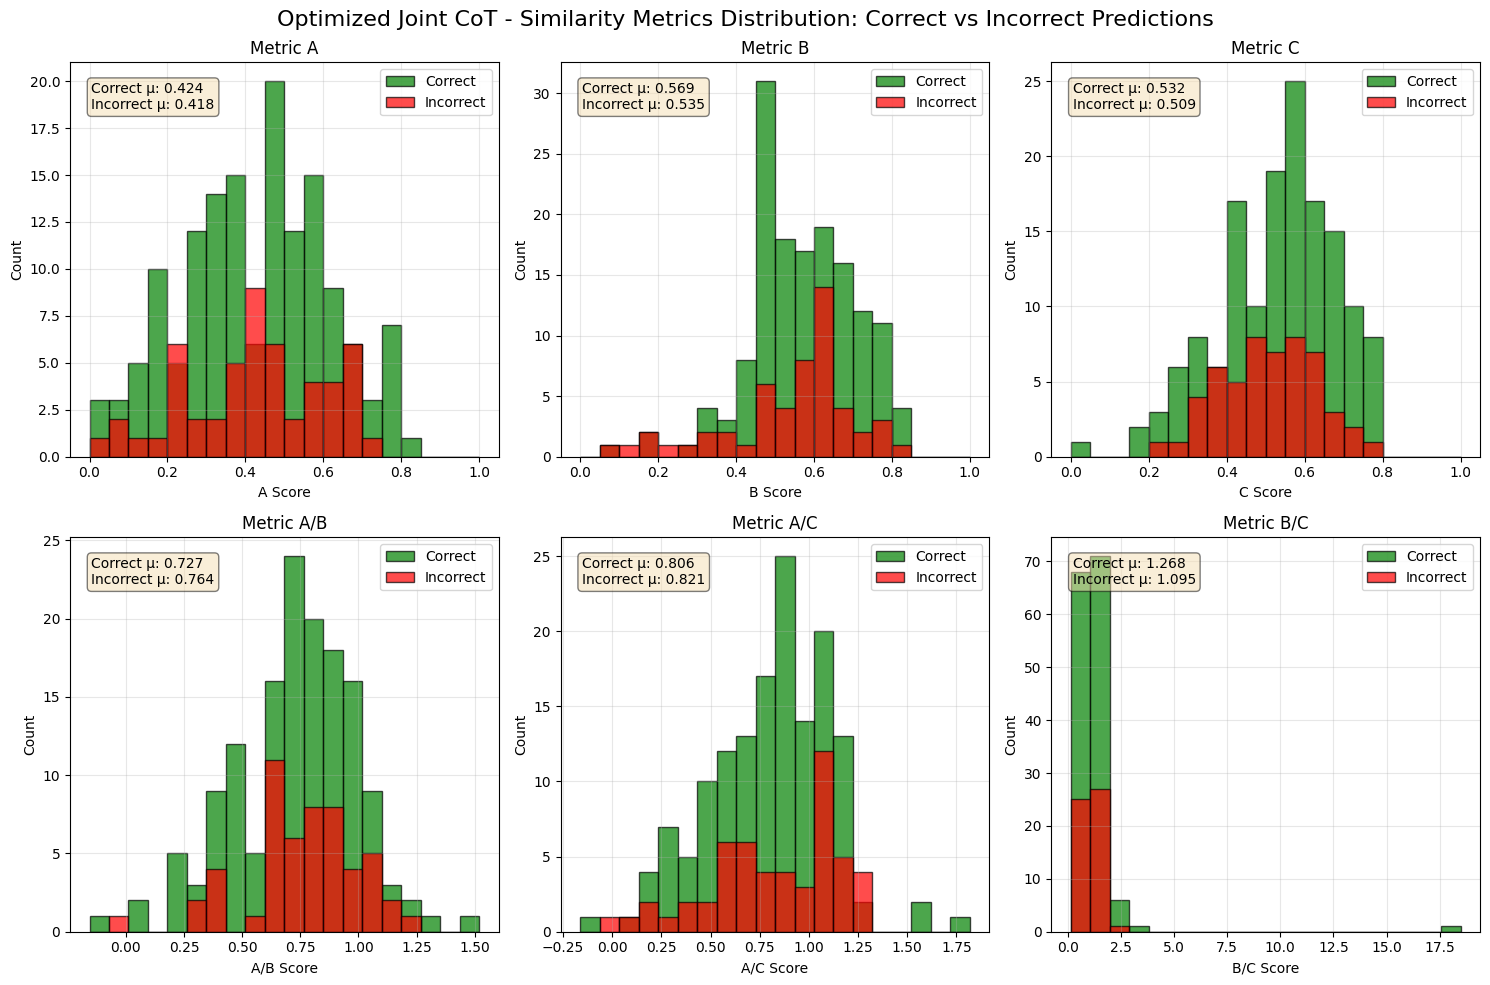

In [ ]:
print("Evaluating optimized model...")
opt_accuracy, opt_results = evaluate_with_similarity_parallel(
    optimized_joint,
    dspy_eval_samples[100:300],  # Use different data for testing
    num_threads=4,
    collect_results=True
)
print(f"Optimized Joint CoT Accuracy: {opt_accuracy:.3f}")

opt_fig = create_similarity_histograms(opt_results, "Optimized Joint CoT")
plt.show()

Evaluating pipeline optimized model...
Average Metric: 153.00 / 200 (76.5%): 100%|██████████| 200/200 [16:15<00:00,  4.88s/it]

2025/08/04 15:13:19 INFO dspy.evaluate.evaluate: Average Metric: 153 / 200 (76.5%)



Optimized Pipeline Accuracy: 76.500


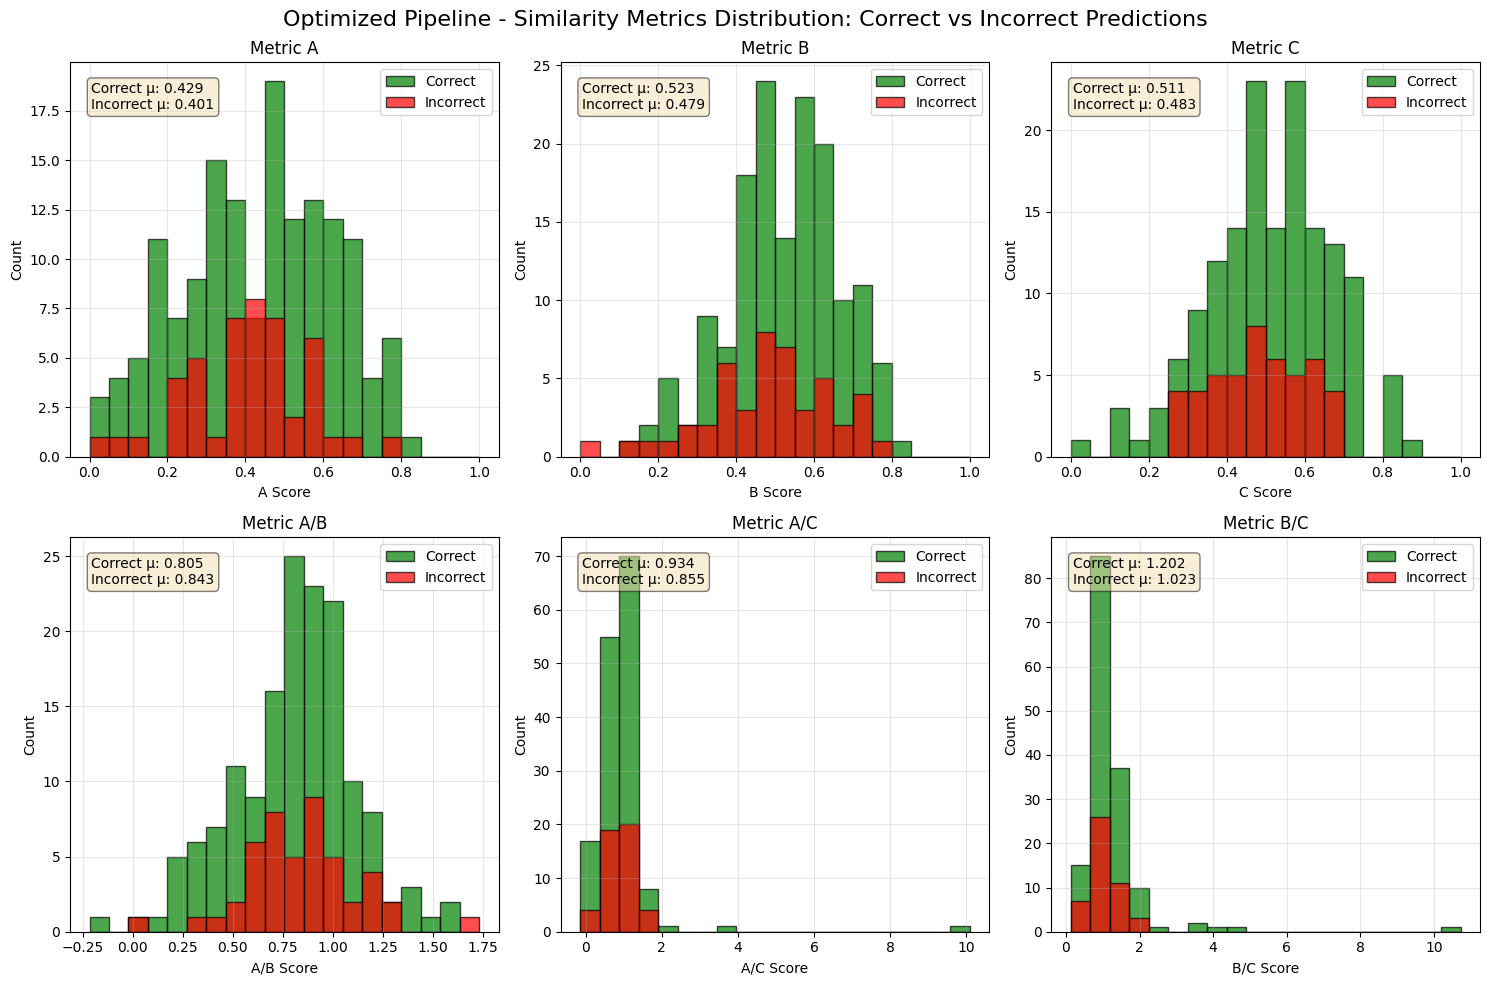

In [ ]:
print("Evaluating pipeline optimized model...")
pipeline_opt_accuracy, pipeline_opt_results = evaluate_with_similarity_parallel(
    optimized_pipeline,
    dspy_eval_samples[100:300],  # Use different data for testing
    num_threads=4,
    collect_results=True
)
print(f"Optimized Pipeline Accuracy: {pipeline_opt_accuracy:.3f}")

pipeline_opt_fig = create_similarity_histograms(pipeline_opt_results, "Optimized Pipeline")
plt.show()